# Notebook imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

%matplotlib inline

# Decision Trees Classification

In [2]:
data = load_breast_cancer()
feature_names = data.feature_names

bc_df = pd.DataFrame(data=data.data, columns=feature_names)
target = pd.Series(data.target)

print('Class Distribution:')
print(target.value_counts())

print('Data Size:')
print(bc_df.shape)

dev_X, test_X, dev_y, test_y = train_test_split(bc_df, target, test_size=0.2, random_state=42)

preprocess = make_column_transformer((StandardScaler(), feature_names))
pipe = make_pipeline(preprocess,
                    DecisionTreeClassifier(max_depth=10, criterion='entropy'))
pipe.fit(dev_X, dev_y)
print(pipe.score(dev_X, dev_y))
print(pipe.score(test_X, test_y))

Class Distribution:
1    357
0    212
Name: count, dtype: int64
Data Size:
(569, 30)
1.0
0.956140350877193


# Decision Trees Regression

In [3]:
data_df = pd.read_csv('Data/AmesHousing_train.csv')

ohe_features = [
    "LotShape",
    "Street",
    "ExterCond",
    "OverallCond",
    "OverallQual",
    "Condition1",
    "Condition2",
    "Functional",
    "MSZoning",
    "FireplaceQu",
]

te_features = ["Neighborhood"]

num_features = [
    "BedroomAbvGr",
    "BsmtFinSF1",
    "BsmtFullBath",
    "EnclosedPorch",
    "GarageArea",
    "LotArea",
    "1stFlrSF",
    "2ndFlrSF",
    "TotalBsmtSF"
]

mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]

dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features))
pipe = make_pipeline(preprocess, DecisionTreeRegressor(max_depth=10))

pipe.fit(dev_X, dev_y)
print(pipe.score(dev_X, dev_y))
print(pipe.score(test_X, test_y))

0.9706255889652167
0.7815661338011053


# Decision Tree Early Stopping - Maximum Depth

In [6]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')

pipe = make_pipeline(preprocess,
                    GridSearchCV(DecisionTreeRegressor(random_state=82), 
                                 param_grid={'max_depth': np.arange(1,10)}, 
                                 return_train_score=True))
pipe.fit(dev_X, dev_y)
grid_search_result = pipe.named_steps['gridsearchcv']
print(f'Best Score: {grid_search_result.best_score_}')
print(f'Best alpha: {grid_search_result.best_params_}')
print(f'Test Score: {pipe.score(test_X, test_y)}')

Best Score: 0.7187960579106621
Best alpha: {'max_depth': 6}
Test Score: 0.7986876384635566


# Decision Tree - Feature Importance

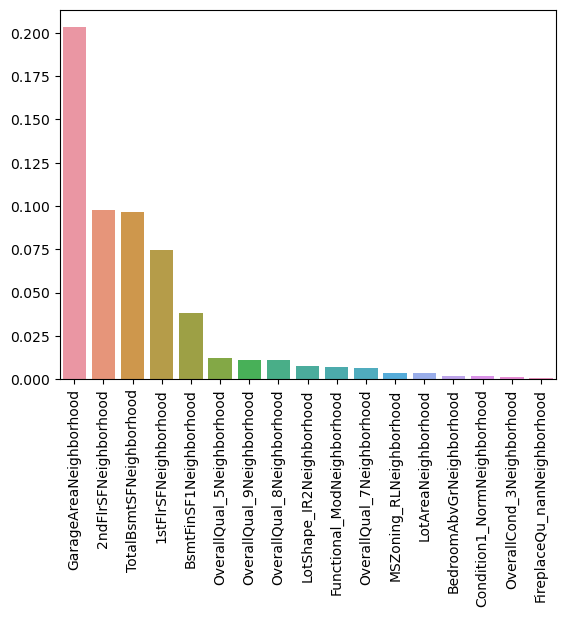

In [5]:
best_tree = grid_search_result.best_estimator_
ohe_feature_names = preprocess.named_transformers_['onehotencoder'].get_feature_names_out().tolist()
te_feature_names = preprocess.named_transformers_['targetencoder'].get_feature_names_out()
feature_names = num_features + ohe_feature_names + te_feature_names
feat_imps = zip(feature_names, best_tree.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
ax = sns.barplot(x=list(feats), y=list(imps))
ax.tick_params(axis='x', rotation=90)

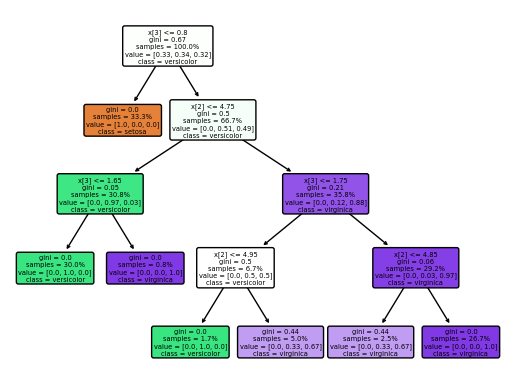

In [6]:
iris = load_iris()
X = iris.data
y = iris.target
dev_X, test_X, dev_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(max_depth=4)
tree.fit(dev_X, dev_y)
tree_plot = plot_tree(tree, 
                      filled=True, 
                      proportion=True, 
                      rounded=True, 
                      class_names=iris.target_names.tolist(), 
                      precision=2)

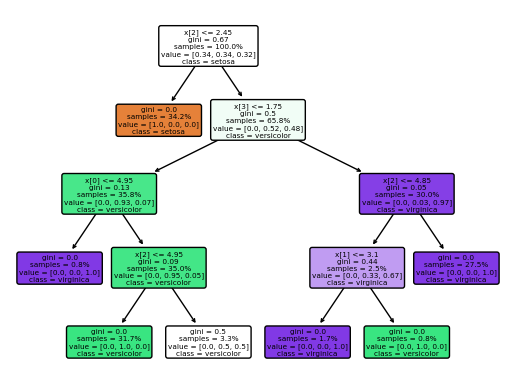

In [7]:
iris = load_iris()
X = iris.data
y = iris.target
dev_X, test_X, dev_y, test_y = train_test_split(X, y, test_size=0.2, random_state=88)

tree = DecisionTreeClassifier(max_depth=4)
tree.fit(dev_X, dev_y)
tree_plot = plot_tree(tree, 
                      filled=True, 
                      proportion=True, 
                      rounded=True, 
                      class_names=iris.target_names.tolist(), 
                      precision=2)

# Simple Ensemble Classifier - Example

In [8]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')
pipe = make_pipeline(preprocess, 
                     VotingRegressor([('logreg', LinearRegression()), ('tree', DecisionTreeRegressor(max_depth=4))]))
pipe.fit(dev_X, dev_y)
pipe.named_steps['votingregressor']
lr, tree = pipe.named_steps['votingregressor'].estimators_
print('Decision tree score:', tree.score(preprocess.transform(test_X), test_y))
print('Linear regression score:', lr.score(preprocess.transform(test_X), test_y))
print('Voting regression score:', pipe.score(test_X, test_y))

Decision tree score: 0.735210428660318
Linear regression score: 0.834410660450086
Voting regression score: 0.8351165365433371


# Bagging - Example

In [9]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')

pipe_bagging_tree = make_pipeline(preprocess, BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=10))
pipe_bagging_tree.fit(dev_X, dev_y)

pipe_bagging_linreg = make_pipeline(preprocess, BaggingRegressor(estimator=LinearRegression(), n_estimators=10))
pipe_bagging_linreg.fit(dev_X, dev_y)

pipe_tree = make_pipeline(preprocess, DecisionTreeRegressor())
pipe_tree.fit(dev_X, dev_y)

pipe_linreg = make_pipeline(preprocess, LinearRegression())
pipe_linreg.fit(dev_X, dev_y)

print('Decision Regressor score:', pipe_tree.score(test_X, test_y))
print('Bagging Tree Regressor score:', pipe_bagging_tree.score(test_X, test_y))
print('--------------------------------------------')
print('Linear Regressor score:', pipe_linreg.score(test_X, test_y))
print('Bagging Linear Regressor score', pipe_bagging_linreg.score(test_X, test_y))

Decision Regressor score: 0.7851931064123427
Bagging Tree Regressor score: 0.8665275876782488
--------------------------------------------
Linear Regressor score: 0.834410660450086
Bagging Linear Regressor score 0.8416083833912567


# Random Forests - Example

In [10]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')

pipe_rf = make_pipeline(preprocess, RandomForestRegressor(random_state=100))
pipe_rf.fit(dev_X, dev_y)
print(pipe_rf.score(dev_X, dev_y))
print(pipe_rf.score(test_X, test_y))

0.9784512495237486
0.8825766248918885


In [11]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')

pipe_rf = make_pipeline(preprocess, RandomForestRegressor(random_state=100))
pipe_rf.fit(dev_X, dev_y)

pipe_tree = make_pipeline(preprocess, DecisionTreeRegressor())
pipe_tree.fit(dev_X, dev_y)

pipe_bagging_tree = make_pipeline(preprocess, BaggingRegressor(estimator=DecisionTreeRegressor(), 
                                                               n_estimators=100, 
                                                               random_state=42))
pipe_bagging_tree.fit(dev_X, dev_y)

print('Random Forest Regressor score:', pipe_rf.score(test_X, test_y))
print('Decision Regressor score:', pipe_tree.score(test_X, test_y))
print('Bagging Tree Regressor score:', pipe_bagging_tree.score(test_X, test_y))

Random Forest Regressor score: 0.8825766248918885
Decision Regressor score: 0.7754952998654446
Bagging Tree Regressor score: 0.8761436562504383


# Random Forests - Hyperparameter tuning

In [12]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')

n_estimators = [100, 200, 300, 400, 500]
oob_score=[]
train_score=[]
test_score=[]

for eatimator in n_estimators:
    pipe_rf = make_pipeline(preprocess, RandomForestRegressor(n_estimators=eatimator,
                                                              random_state=100,oob_score=True))
    pipe_rf.fit(dev_X, dev_y)
    train_score.append(pipe_rf.score(dev_X, dev_y))
    test_score.append(pipe_rf.score(test_X, test_y))
    rt = pipe_rf.named_steps['randomforestregressor']
    oob_score.append(rt.oob_score_)
    
best_index = np.argmax(oob_score)
best_n_estimator = n_estimators[best_index]
best_pipe_rf = make_pipeline(preprocess, RandomForestRegressor(n_estimators=best_n_estimator,
                                                              random_state=100,oob_score=True))
best_pipe_rf.fit(dev_X,dev_y)
print(f'Randorn Forest Regressor score: {best_pipe_rf.score(test_X, test_y)}, # of estimate rs:{best_n_estimator}')   


Randorn Forest Regressor score: 0.8826187002717545, # of estimate rs:500


In [13]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')

n_estimators = [100, 200, 300, 400, 500]
oob_score=[]
train_score=[]
test_score=[]

for eatimator in n_estimators:
    pipe_rf = make_pipeline(preprocess, RandomForestRegressor(n_estimators=eatimator,
                                                              random_state=100,oob_score=True, 
                                                              warm_start=True))
    pipe_rf.fit(dev_X, dev_y)
    train_score.append(pipe_rf.score(dev_X, dev_y))
    test_score.append(pipe_rf.score(test_X, test_y))
    rt = pipe_rf.named_steps['randomforestregressor']
    oob_score.append(rt.oob_score_)
    
best_index = np.argmax(oob_score)
best_n_estimator = n_estimators[best_index]
best_pipe_rf = make_pipeline(preprocess, RandomForestRegressor(n_estimators=best_n_estimator,
                                                              random_state=100,oob_score=True))
best_pipe_rf.fit(dev_X,dev_y)
print(f'Randorn Forest Regressor score: {best_pipe_rf.score(test_X, test_y)}, # of estimate rs:{best_n_estimator}')  

Randorn Forest Regressor score: 0.8826187002717545, # of estimate rs:500


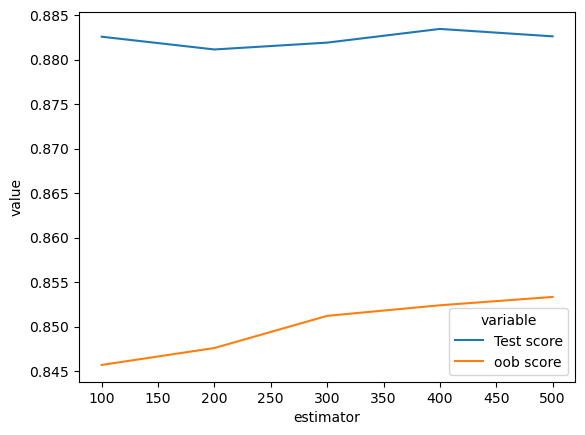

In [14]:
df = pd.DataFrame({'estimator':n_estimators, 'Test score':test_score, 'oob score':oob_score})

sns.lineplot(x='estimator', y='value', hue='variable', 
             data=pd.melt(df, ['estimator']))
plt.show()

# Random Forests - Feature importances

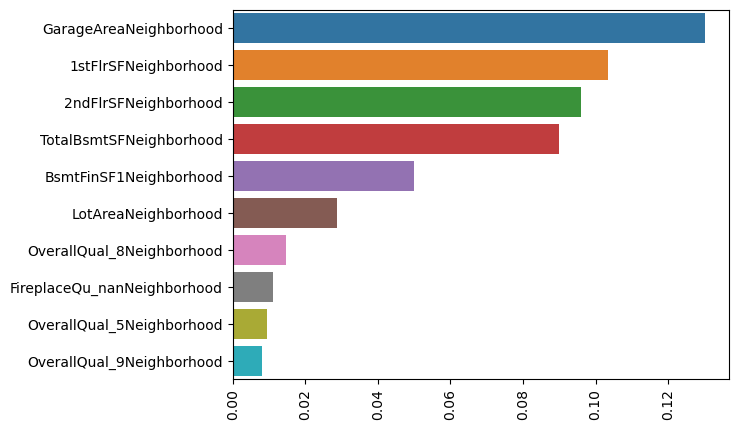

In [15]:
rf = best_pipe_rf.named_steps['randomforestregressor']
ohe_feature_names = preprocess.named_transformers_['onehotencoder'].get_feature_names_out().tolist()
te_feature_names = preprocess.named_transformers_['targetencoder'].get_feature_names_out()
feature_names = num_features + ohe_feature_names + te_feature_names
feat_imps = zip(feature_names, rf.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
ax = sns.barplot(y=list(feats[:10]), x=list(imps[:10]))
ax.tick_params(axis='x', rotation=90)

# Adaboost Classifier example

In [17]:
data = load_breast_cancer()
feature_names = data.feature_names

bc_df = pd.DataFrame(data=data.data, columns=feature_names)
target = pd.Series(data.target)

dev_X, test_X, dev_y, test_y = train_test_split(bc_df, target, test_size=0.2, random_state=42)

preprocess = make_column_transformer((StandardScaler(), feature_names))

pipe_abs = make_pipeline(preprocess, AdaBoostClassifier(random_state=42))
pipe_abs.fit(dev_X, dev_y)
print(f'AdaBoost Classifier score: {pipe_abs.score(test_X, test_y)}')

AdaBoost Classifier score: 0.9736842105263158


# Adaboost Regressor example

In [19]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')
pipe_ab = make_pipeline(preprocess, AdaBoostRegressor(random_state=42))
pipe_ab.fit(dev_X, dev_y)
print(f'AdaBoost Regression score: {pipe_ab.score(test_X, test_y)}')

AdaBoost Regression score: 0.7864157698170654


# Adaboost Regressor example

In [21]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')

pipe_abr = make_pipeline(preprocess, AdaBoostRegressor(random_state=42))
pipe_abr.fit(dev_X, dev_y)

pipe_tree = make_pipeline(preprocess, DecisionTreeRegressor())
pipe_tree.fit(dev_X, dev_y)

pipe_bagging_tree = make_pipeline(preprocess, BaggingRegressor(estimator=DecisionTreeRegressor(), 
                                                               n_estimators=50, 
                                                               random_state=42))
pipe_bagging_tree.fit(dev_X, dev_y)

print(f'AdaBoost Regression score: {pipe_abr.score(test_X, test_y)}')
print(f'Decision Regressor score: {pipe_tree.score(test_X, test_y)}')
print(f'Bagging Tree Regressor score: {pipe_bagging_tree.score(test_X, test_y)}')

AdaBoost Regression score: 0.7864157698170654
Decision Regressor score: 0.7799771773095762
Bagging Tree Regressor score: 0.8754749112599263


In [22]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')

pipe_abr = make_pipeline(preprocess, AdaBoostRegressor(DecisionTreeRegressor() ,random_state=42))
pipe_abr.fit(dev_X, dev_y)

pipe_tree = make_pipeline(preprocess, DecisionTreeRegressor())
pipe_tree.fit(dev_X, dev_y)

pipe_bagging_tree = make_pipeline(preprocess, BaggingRegressor(estimator=DecisionTreeRegressor(), 
                                                               n_estimators=50, 
                                                               random_state=42))
pipe_bagging_tree.fit(dev_X, dev_y)

print(f'AdaBoost Regression score: {pipe_abr.score(test_X, test_y)}')
print(f'Decision Regressor score: {pipe_tree.score(test_X, test_y)}')
print(f'Bagging Tree Regressor score: {pipe_bagging_tree.score(test_X, test_y)}')

AdaBoost Regression score: 0.88292753659323
Decision Regressor score: 0.7508164579887824
Bagging Tree Regressor score: 0.8754749112599263


# Adaboost Regressor - hyperparameter tuning

In [26]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')
pipe = make_pipeline(preprocess, GridSearchCV(estimator=AdaBoostRegressor(), 
                                              param_grid={'n_estimators':[50, 100, 200], 
                                                          'learning_rate':np.logspace(-3,0,4)}))
pipe.fit(dev_X, dev_y)
grid_search_result = pipe.named_steps['gridsearchcv']
print(f'Best score: {grid_search_result.best_score_}')
print(f'Best alpha: {grid_search_result.best_params_}')
print(f'Test score: {pipe.score(test_X, test_y)}')

Best score: 0.7707241165155989
Best alpha: {'learning_rate': 1.0, 'n_estimators': 50}
Test score: 0.7896397447879497


# GradientBoostingRegressor - Example

In [28]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')

pipe_gbr = make_pipeline(preprocess, GradientBoostingRegressor(random_state=42))
pipe_gbr.fit(dev_X, dev_y)
print(f'Gradient Boosting Regrassion score: {pipe_gbr.score(test_X, test_y)}')

Gradient Boosting Regrassion score: 0.8943442576987566


# XGBoost - Example

In [7]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')
pipe_xg = make_pipeline(preprocess, XGBRegressor(random_state=42))
pipe_xg.fit(dev_X, dev_y)
print(f'XGBoost Regressor score: {pipe_xg.score(test_X, test_y)}')

XGBoost Regressor score: 0.8915341970729329


# LightGBM - Example

In [4]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')
pipe_xgb = make_pipeline(preprocess, LGBMRegressor(random_state=42))
pipe_xgb.fit(dev_X, dev_y)
print(f'LightGBM Regressor score: {pipe_xgb.score(test_X, test_y)}')

LightGBM Regressor score: 0.8816073432802085


# CatBoost - Example

In [7]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]


dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, 
                                                test_size=0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), num_features),
                                 (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                 (TargetEncoder(handle_unknown='value'), te_features),
                                    remainder='passthrough')
pipe_cat = make_pipeline(preprocess, CatBoostRegressor(random_state=42, verbose=False))
pipe_cat.fit(dev_X, dev_y)
print(f'Catboost Regressor score: {pipe_cat.score(test_X, test_y)}')

Catboost Regressor score: 0.9156817199177658
